In [104]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [106]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [107]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# MLP (PyTorch-ify)

In [127]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),      generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [128]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[Xtr[ix]]
    x = emb.view(-1, n_embd * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Ytr[ix])

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i <= 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    if i >= 1000:
        break

      0/ 200000: 3.2870


In [129]:
print(loss)

tensor(2.2807, grad_fn=<NllLossBackward0>)


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

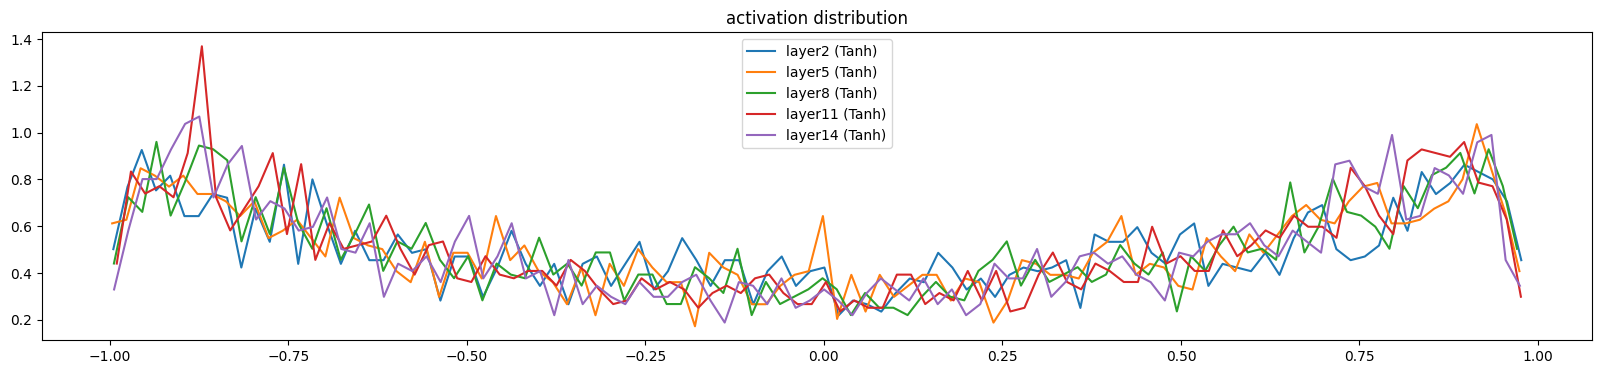

In [130]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__:>10}): mean {t.mean():+.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%')

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

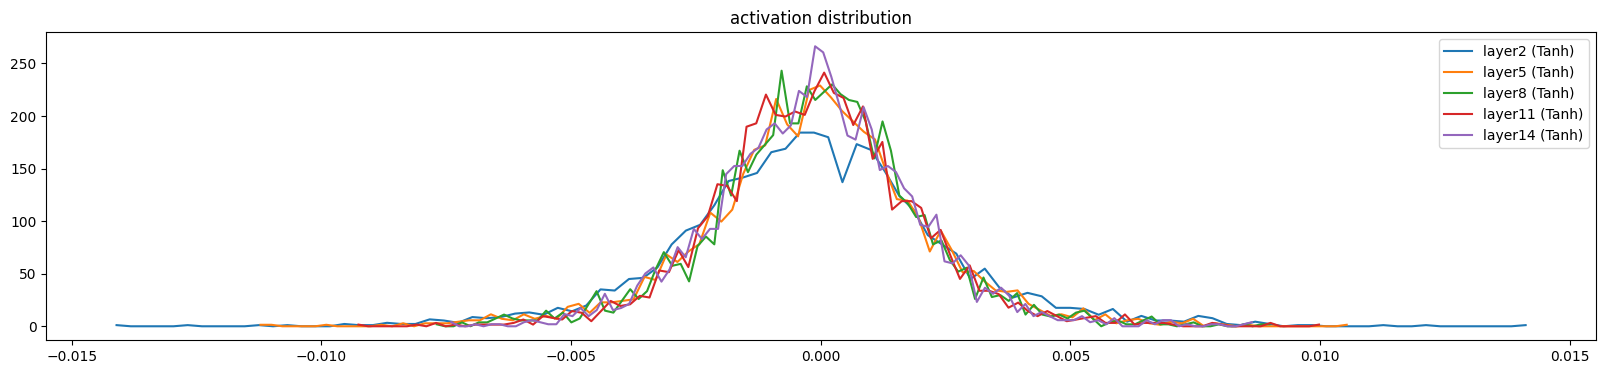

In [131]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:>10}): mean {t.mean():+.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%')

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

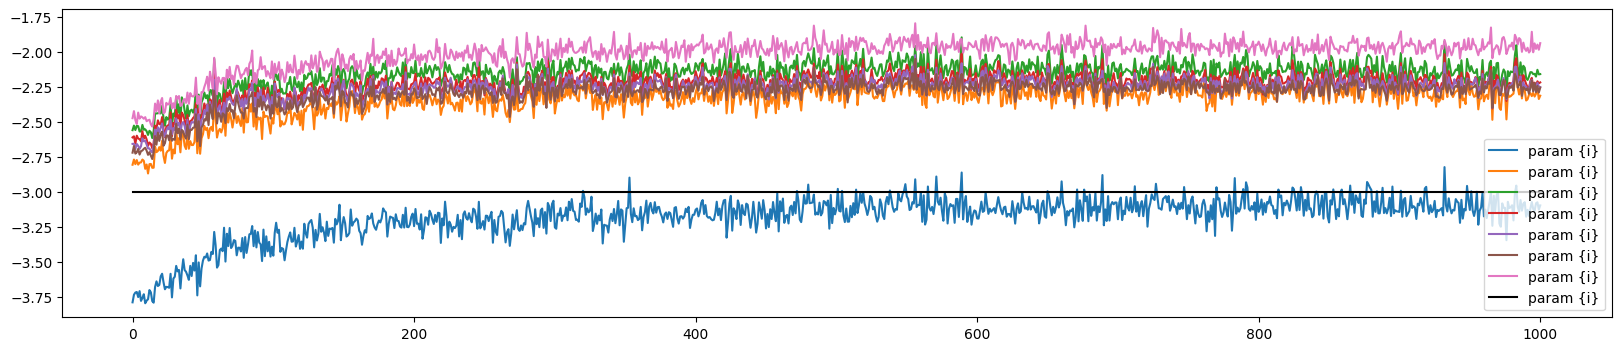

In [132]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)